Q-learning中使用的表格存储Q(s, a)在数据量很大或者状态连续的时候并不实用

考虑使用函数拟合的方法估计Q值, 将Q参数化为Q_theta. 这种方法存在一定的精度损失, 被称为近似方法

DQN(Deep Q Network)方法: 可以**解决连续状态下离散动作**的问题

引入环境: [CartPole](https://github.com/openai/gym/wiki/CartPole-v0)

在车杆环境中，有一辆小车，智能体的任务是通过左右移动保持车上的杆竖直，若杆的倾斜度数过大，或者车子离初始位置左右的偏离程度过大，或者坚持时间到达 200 帧，则游戏结束。

智能体的状态是一个维数为 4 的向量，每一维都是连续的，其动作是离散的，动作空间大小为 2，详情参见表 7-1 和表 7-2。

在游戏中每坚持一帧，智能体能获得分数为 1 的奖励，坚持时间越长，则最后的分数越高，坚持 200 帧即可获得最高的分数。

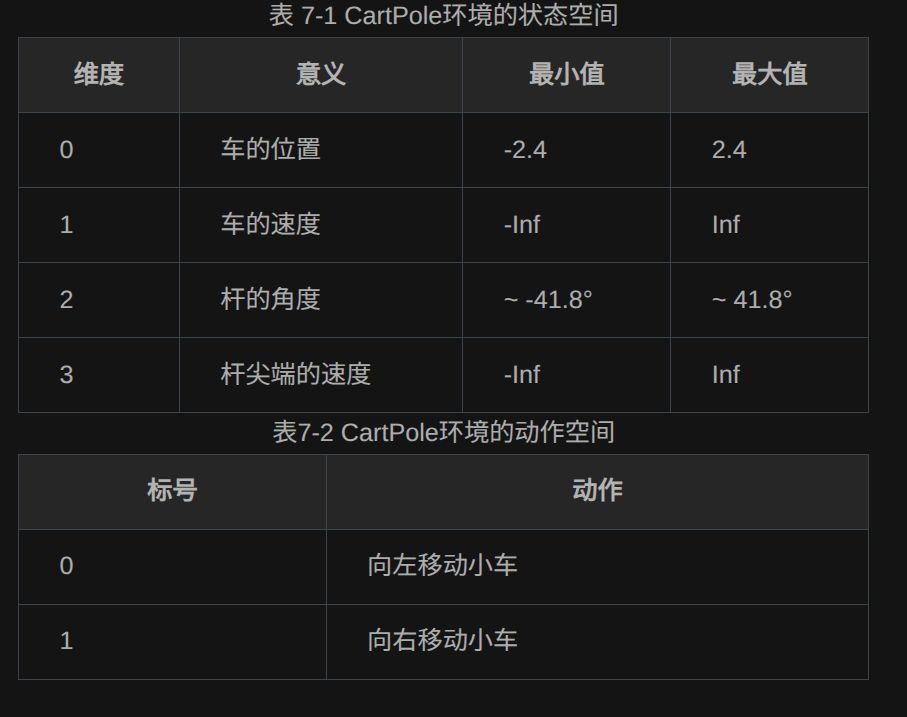

"拟合"使用的是神经网络, 称为Q net, 回忆Q-learning的更新方式:

$$Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha[R_t+\gamma\max_aQ(s_{t+1},a)-Q(s_t,a_t)]$$

 将其修改为损失函数的样子:

 $$\omega^*=\arg\min_\omega\frac{1}{2N}\sum_{i=1}^N\left[Q_\omega\left(s_i,a_i\right)-\left(r_i+\gamma\max_{a^{\prime}}Q_\omega\left(s_i^{\prime},a^{\prime}\right)\right)\right]^2$$

 即可用神经网络进行更新

 为了更好地将 Q-learning 和深度神经网络结合，DQN 算法采用了**经验回放**（experience replay）方法，具体做法为维护一个回放缓冲区，将每次从环境中采样得到的四元组数据（状态、动作、奖励、下一状态）存储到回放缓冲区中，训练 Q 网络的时候再从回放缓冲区中随机采样若干数据来进行训练

 这样做的两个好处:
 - 使样本满足独立假设
 - 提高样本效率, 使得每一个样本可以被使用多次

 为了增强神经网络训练的稳定性, 考虑使用**目标网络**, 即延缓更新逼近目标 $r_i+\gamma\max_{a^{\prime}}Q_\omega\left(s_i^{\prime},a^{\prime}\right)$, 为了实现,需要使用两套Q网络,具体流程如下:

 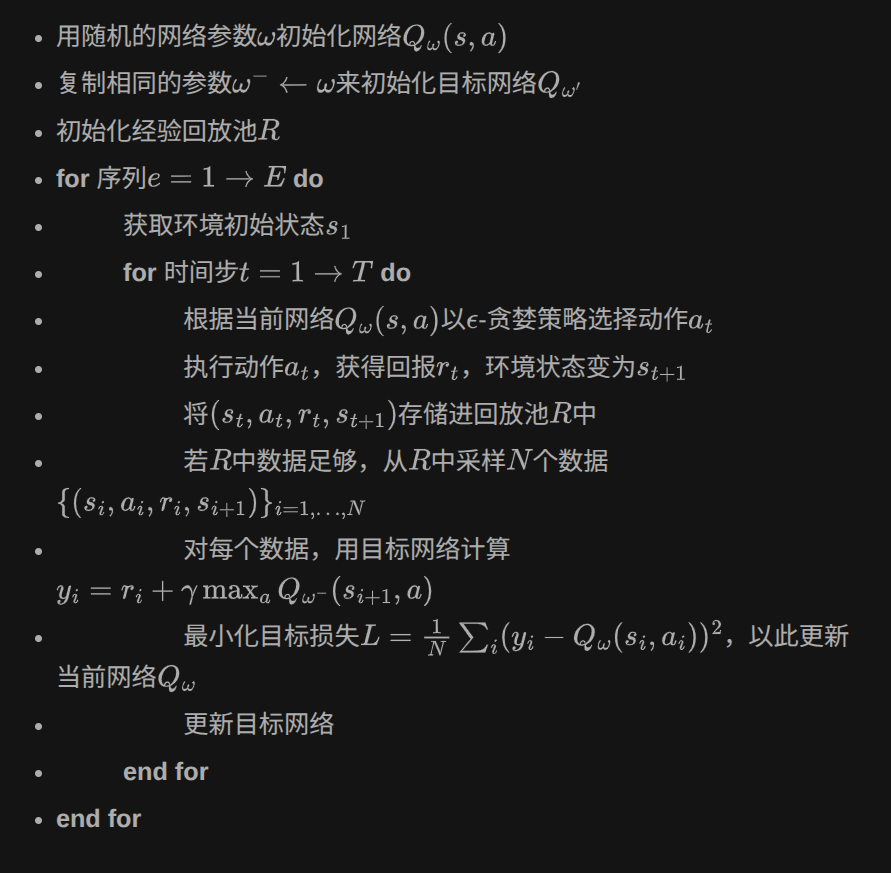

 下面进行代码实践

Iteration 9: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s, episode=500, return=200.000]


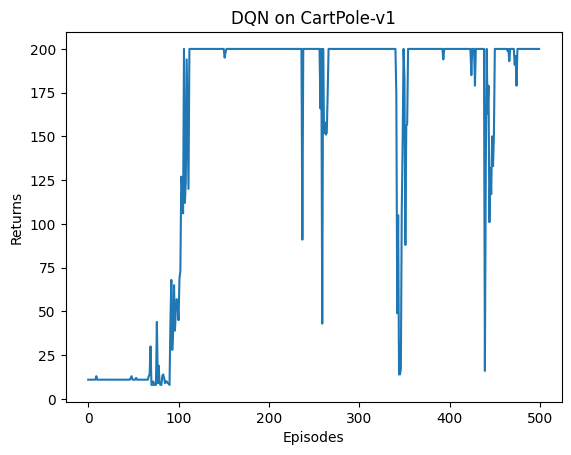

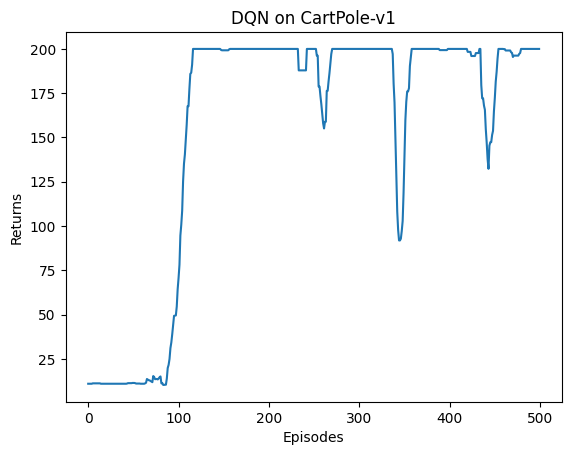

In [ ]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

class ReplayBuffer:
    """Experience reply pool"""
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)


class Qnet(torch.nn.Module):
    """Only one hide layer, Qnet"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class DQN:
    """DQN Algorithm"""
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        # Q network
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        #Q target network
        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype = torch.float). to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q value
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name ='CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

reply_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

return_list = []

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

for i in range(10):
    with tqdm(total = int(num_episodes / 10), desc = 'Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            steps = 0
            episode_return = 0
            state = env.reset(seed = 0)[0]
            done =False
            while not done and steps < 200:
                action = agent.take_action(state)
                steps += 1
                next_state, reward, done, _, __ = env.step(action)
                reply_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if reply_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = reply_buffer.sample(batch_size)
                    transition_dict = {
                        'states':b_s,
                        'actions':b_a,
                        'next_states':b_ns,
                        'rewards':b_r,
                        'dones':b_d
                    }
                    agent.update(transition_dict)

            return_list.append(episode_return)
            if(i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode +1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()